In [1]:
# prompt: kết nói gg drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
! pip install ultralytics
! pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 62.9 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
import torch
import torch.nn as nn
import timm
import os
import cv2
import matplotlib.pyplot as plt
import json
import cv2
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Load model yolo and extract box

In [4]:
def visualize_bbox(image_labels, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX):
    img = cv2.imread(image_labels)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

{'name': 'text', 'class': 0, 'confidence': 0.9353, 'box': {'x1': 722.61121, 'y1': 256.25433, 'x2': 998.28986, 'y2': 344.05188}}


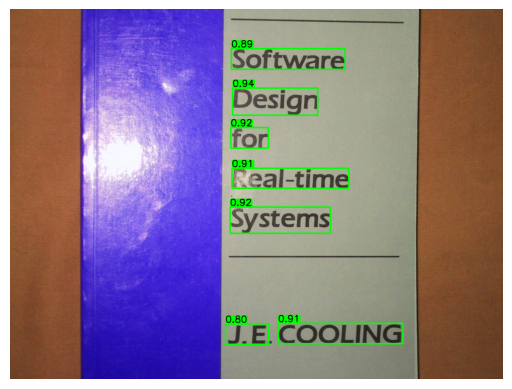

In [5]:
folder_yolo = "/content/drive/MyDrive/Code/cv/OCR/model/yolov8_best.pt"
model_yolo = YOLO(folder_yolo)
image_test = "/content/drive/MyDrive/Code/cv/OCR/data/yolo_data/test/images/IMG_1282.JPG"
results = model_yolo(image_test, verbose=False)
predictions = json.loads(results[0].to_json())
print(predictions[0])
visualized_img = visualize_bbox(image_test, predictions, 0.70)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()

# data_recognizer

In [4]:
def extract_data_from_xml(root_dir):
    xml_path = os.path.join(root_dir, 'words.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []
    for img in root:
        bbs_of_img = []
        labels_of_img = []
        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                if not bb[0].text.isalnum():
                    continue
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue
                bbs_of_img.append([float(bb.attrib['x']), float(bb.attrib['y']), float(bb.attrib['width']), float(bb.attrib['height'])])
                labels_of_img.append(bb[0].text.lower())
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)
    return img_paths, img_sizes, img_labels, bboxes

In [5]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    count = 0
    labels = []
    for img_path, img_label, bbox in zip(img_paths, img_labels, bboxes):
      img = Image.open(img_path)
      for img_label, bb in zip(img_label, bbox):
        cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))
        if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
            continue
        if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
            continue
        filename = f"{count:06d}.jpg"
        cropped_img.save(os.path.join(save_dir, filename))

        new_img_path = os.path.join(save_dir, filename)
        label = new_img_path + '\t' + img_label
        labels.append(label)
        count += 1
    print(f"Created {count} images")
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f"{label}\n")

In [6]:
data_raw_file = '/content/drive/MyDrive/Code/cv/OCR/data_raw/SceneTrialTrain'
save_dir = '/content/drive/MyDrive/Code/cv/OCR/data/text_recognizer_data'
# img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(data_raw_file)
# split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

In [7]:
root_dir = save_dir

img_paths = []
labels = []

with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")

Total images: 1088


In [8]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)

letters = sorted(list(set(list(letters))))
chars = "".join(letters)

blank_char = '-'
chars += blank_char
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [9]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
max_label_len = max([len(label) for label in labels])
char_to_idx, idx_to_char, max_label_len

({'-': 1,
  '0': 2,
  '1': 3,
  '2': 4,
  '3': 5,
  '4': 6,
  '5': 7,
  '6': 8,
  '7': 9,
  '8': 10,
  '9': 11,
  'a': 12,
  'b': 13,
  'c': 14,
  'd': 15,
  'e': 16,
  'f': 17,
  'g': 18,
  'h': 19,
  'i': 20,
  'j': 21,
  'k': 22,
  'l': 23,
  'm': 24,
  'n': 25,
  'o': 26,
  'p': 27,
  'q': 28,
  'r': 29,
  's': 30,
  't': 31,
  'u': 32,
  'v': 33,
  'w': 34,
  'x': 35,
  'y': 36,
  'z': 37},
 {1: '-',
  2: '0',
  3: '1',
  4: '2',
  5: '3',
  6: '4',
  7: '5',
  8: '6',
  9: '7',
  10: '8',
  11: '9',
  12: 'a',
  13: 'b',
  14: 'c',
  15: 'd',
  16: 'e',
  17: 'f',
  18: 'g',
  19: 'h',
  20: 'i',
  21: 'j',
  22: 'k',
  23: 'l',
  24: 'm',
  25: 'n',
  26: 'o',
  27: 'p',
  28: 'q',
  29: 'r',
  30: 's',
  31: 't',
  32: 'u',
  33: 'v',
  34: 'w',
  35: 'x',
  36: 'y',
  37: 'z'},
 14)

In [10]:
def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.long
    )
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [11]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32, 100)),
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5
        ),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=2, shear=2),
        transforms.RandomPerspective(
            distortion_scale=0.4,
            p=0.5,
            interpolation=3
        ),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        # transforms.RandomErasing(p=0.5, scale=(0.01, 0.3), ratio = (1, 1), value=0, inplace=True),
        # # transforms.RandomCrop(32, padding=2),
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomRotation(5)
    ]),
    'val': transforms.Compose([
        transforms.Resize((32, 100)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
}

In [13]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [14]:
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label,
                self.char_to_idx,
                self.max_label_len
            )
        return img, encoded_label, label_len

In [15]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

In [16]:
print(f"Train dataset: {len(train_dataset)}", f"Val dataset: {len(val_dataset)}", f"Test dataset: {len(test_dataset)}", sep='\n')

Train dataset: 761
Val dataset: 218
Test dataset: 109


In [17]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

['new', 'castle', 'construction', 'signo', 'nokia', 'food', 'weather', 'u', 'design', 'do', 'maintenance', 'microsoft', 'ian', 'to', 'box', 'serious', 'refistered', 'lager', 'wiley', 'eqpt', 'alarm', 'written', 'red', 'information', 'flying', 'office', 'w', 'golf', 'sound', 'cause', 'seatrade', 'festivals', 'savers', 'xtra', 'orange', 'boundary', 'h', 'wallace', 'teeth', 'only', 'road', 'clock', 'are', 'fresh', 'st', 'section', 'county', 'london', 'coleman', 'proceed', 'on', 'exit', 'lloyds', 'spencer', 'students', 'evening', 'know', 'these', 'up', 'avery', 'r', 'on', 'nokia', 'phones', 'science', 'services', 'net', 'hygiene', 'a4382', 'long', 'rbon', 'to', 'like', 'java', 'bjork', 'strategy', 'draught', 'dlr', 'lion', 'the', 'county', '4', 'lounge', '3', 'mark', 'software', 'a', 'chelmsford', 'series', 'lock', 'fca', 'centre', 'a', 'toilet', 'scroll', 'osborne', 'middleborough', 'centre', 'lift', 'saxons', 'riverside', 'books', 'site', 'visits', 'bison', 'sack', 'daily', 'the', 'econo

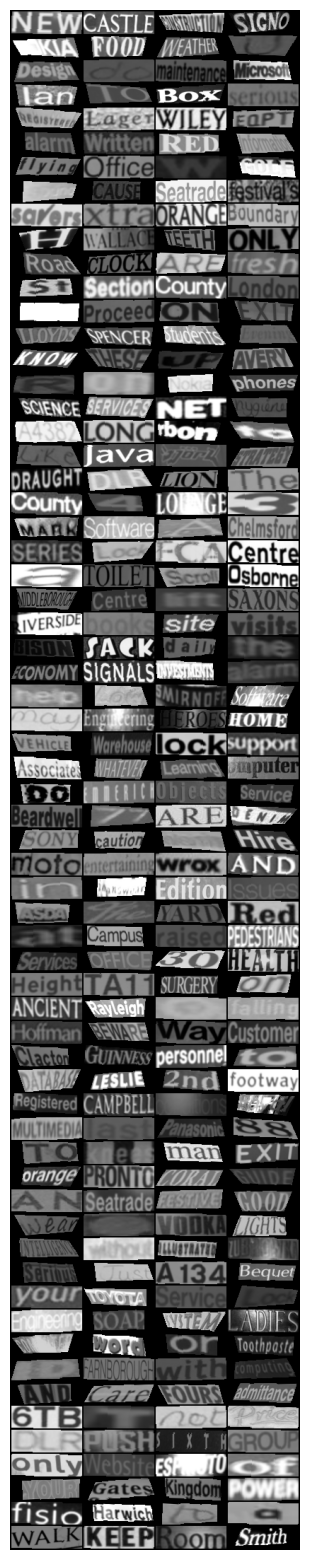

In [18]:
train_features, train_labels, train_lengths = next(iter(train_loader))

def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

# Model crnnwithResnet

In [19]:
# class PatchExtractor(nn.Module):
#     def __init__(self, img_size=224, patch_size=16):
#         super(PatchExtractor, self).__init__()
#         self.img_size = img_size
#         self.num_patches = (img_size // patch_size) ** 2
#         self.patch_size = patch_size

#     def forward(self, x):
#         B, C, H, W = x.shape
#         if H != self.img_size or W != self.img_size:
#             x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
#         patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
#         patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
#         return patches


# class Resnet(nn.Module):
#     def __init__(self):
#         super(Resnet, self).__init__()
#         resnet = timm.create_model(
#             'resnet101',
#             in_chans=1,
#             pretrained=True
#         )
#         module = list(resnet.children())[:-2]
#         module.append(nn.AdaptiveAvgPool2d((1, None)))
#         self.backbone = nn.Sequential(*module)
#         for parameter in self.backbone.parameters():
#             parameter.requires_grad = False
#         for parameter in self.backbone[-3:].parameters():
#             parameter.requires_grad = True

#     def forward(self, x):
#         return self.backbone(x)

# class ViTswithresnet(nn.Module):
#     def __init__(self, n_head=8, dropout=0.1, img_size=224, num_patches=16):
#         super(ViTswithresnet, self).__init__()
#         self.num_patches = num_patches
#         self.PatchExtractor = PatchExtractor(img_size=img_size, patch_size=num_patches)
#         self.Resnet = Resnet()

#         self.pos_embedding = nn.Parameter(torch.randn(1, (img_size // num_patches) ** 2 + 1, 1024))
#         self.transformers = nn.TransformerEncoderLayer(
#             d_model=1024,
#             nhead=n_head,
#             dim_feedforward=2048,
#             dropout=dropout,
#             activation='relu',
#             batch_first=True
#         )
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(2048 * 7, 1024)
#         self.classification = nn.Sequential(
#             nn.Linear(1024, 37),
#             # nn.LogSoftmax(dim=2)
#         )

#     def forward(self, x):
#         B = x.shape[0]
#         patches = self.PatchExtractor(x)  # [B, C, H, W, patch]
#         input = []
#         resized_patches = []

#         for i in range(self.num_patches):
#             patch = patches[:, :, :, :, i]  # Chọn từng patch theo thứ tự
#             resized_patch = F.interpolate(patch, size=(224, 224), mode='bilinear', align_corners=False)
#             resized_patches.append(resized_patch)  # [-1, 1, 224, 224]

#         resized_patches = torch.stack(resized_patches, dim=1)
#         features = []

#         for i in range(self.num_patches):
#             patch = resized_patches[:, i]
#             feature = self.Resnet(patch)
#             feature = self.flatten(feature)  # [-1, 2048 * 7]
#             feature = self.fc(feature)  # [-1, 1024]
#             features.append(feature)

#         features = torch.stack(features, dim=1)  # [B, num_patches, 1024]
#         input = features + self.pos_embedding[:, :features.size(1), :]  # Thêm pos_embedding

#         output = self.transformers(input)# thêm mask
#         output = output[:, 0]
#         output = self.classification(output)
#         return output


In [20]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()

        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )

        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.gru = nn.LSTM(
            input_size=1024,
            hidden_size=hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x) # shape: (bs, c, h, w)
        x = x.permute(0, 3, 1, 2) # shape: (bs, w, c, h)
        x = x.view(x.size(0), x.size(1), -1)  # Remove h: (bs, w, c)
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x) # shape: (bs, seq_len, n_classes)
        x = x.permute(1, 0, 2) # Based on CTC # (seq_len, bs, n_classes)

        return x

In [33]:
hidden_size = 128
n_layers = 3
dropout_prob = 0.5
unfreeze_layers=4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([14, 64, 37])


In [22]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(
                outputs, labels, logits_lens, labels_len
            )
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [34]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_wts = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Logits lens (sequence length for CTC loss)
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            # Compute the loss
            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()

            # Clip gradients to avoid explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            batch_train_losses.append(loss.item())

        # Calculate average train loss
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        # Evaluate on validation set
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

        # Check if current validation loss is the best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()  # Save best model weights
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1

        # Early stopping based on patience
        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

    # Load the best model weights before returning
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return train_losses, val_losses



In [35]:
epochs = 50
lr = 0.001
weight_decay=1e-4
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [36]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 2.0208	Val loss: 1.5204
EPOCH 2:	Train loss: 1.4897	Val loss: 1.5939
EPOCH 3:	Train loss: 1.4716	Val loss: 1.6386
EPOCH 4:	Train loss: 1.4873	Val loss: 1.5427
EPOCH 5:	Train loss: 1.4286	Val loss: 1.4847
EPOCH 6:	Train loss: 1.4161	Val loss: 1.4635
EPOCH 7:	Train loss: 1.3875	Val loss: 1.4400
EPOCH 8:	Train loss: 1.3536	Val loss: 1.3996
EPOCH 9:	Train loss: 1.3052	Val loss: 1.3709
EPOCH 10:	Train loss: 1.2878	Val loss: 1.3457
EPOCH 11:	Train loss: 1.2627	Val loss: 1.3342
EPOCH 12:	Train loss: 1.2420	Val loss: 1.3060
EPOCH 13:	Train loss: 1.2196	Val loss: 1.2947
EPOCH 14:	Train loss: 1.1889	Val loss: 1.2967
EPOCH 15:	Train loss: 1.1682	Val loss: 1.3019
EPOCH 16:	Train loss: 1.1542	Val loss: 1.2911
EPOCH 17:	Train loss: 1.1225	Val loss: 1.2987
EPOCH 18:	Train loss: 1.1103	Val loss: 1.2423
EPOCH 19:	Train loss: 1.0824	Val loss: 1.2548
EPOCH 20:	Train loss: 1.0512	Val loss: 1.2515
EPOCH 21:	Train loss: 1.0181	Val loss: 1.1946
EPOCH 22:	Train loss: 1.0122	Val loss: 1.17

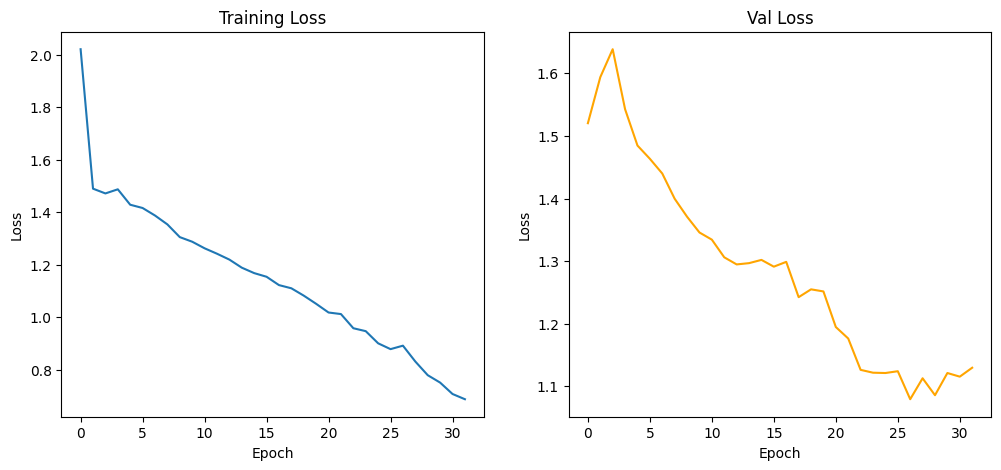

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [38]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  1.1295359219823564
Test loss:  1.5311663842626981


In [39]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

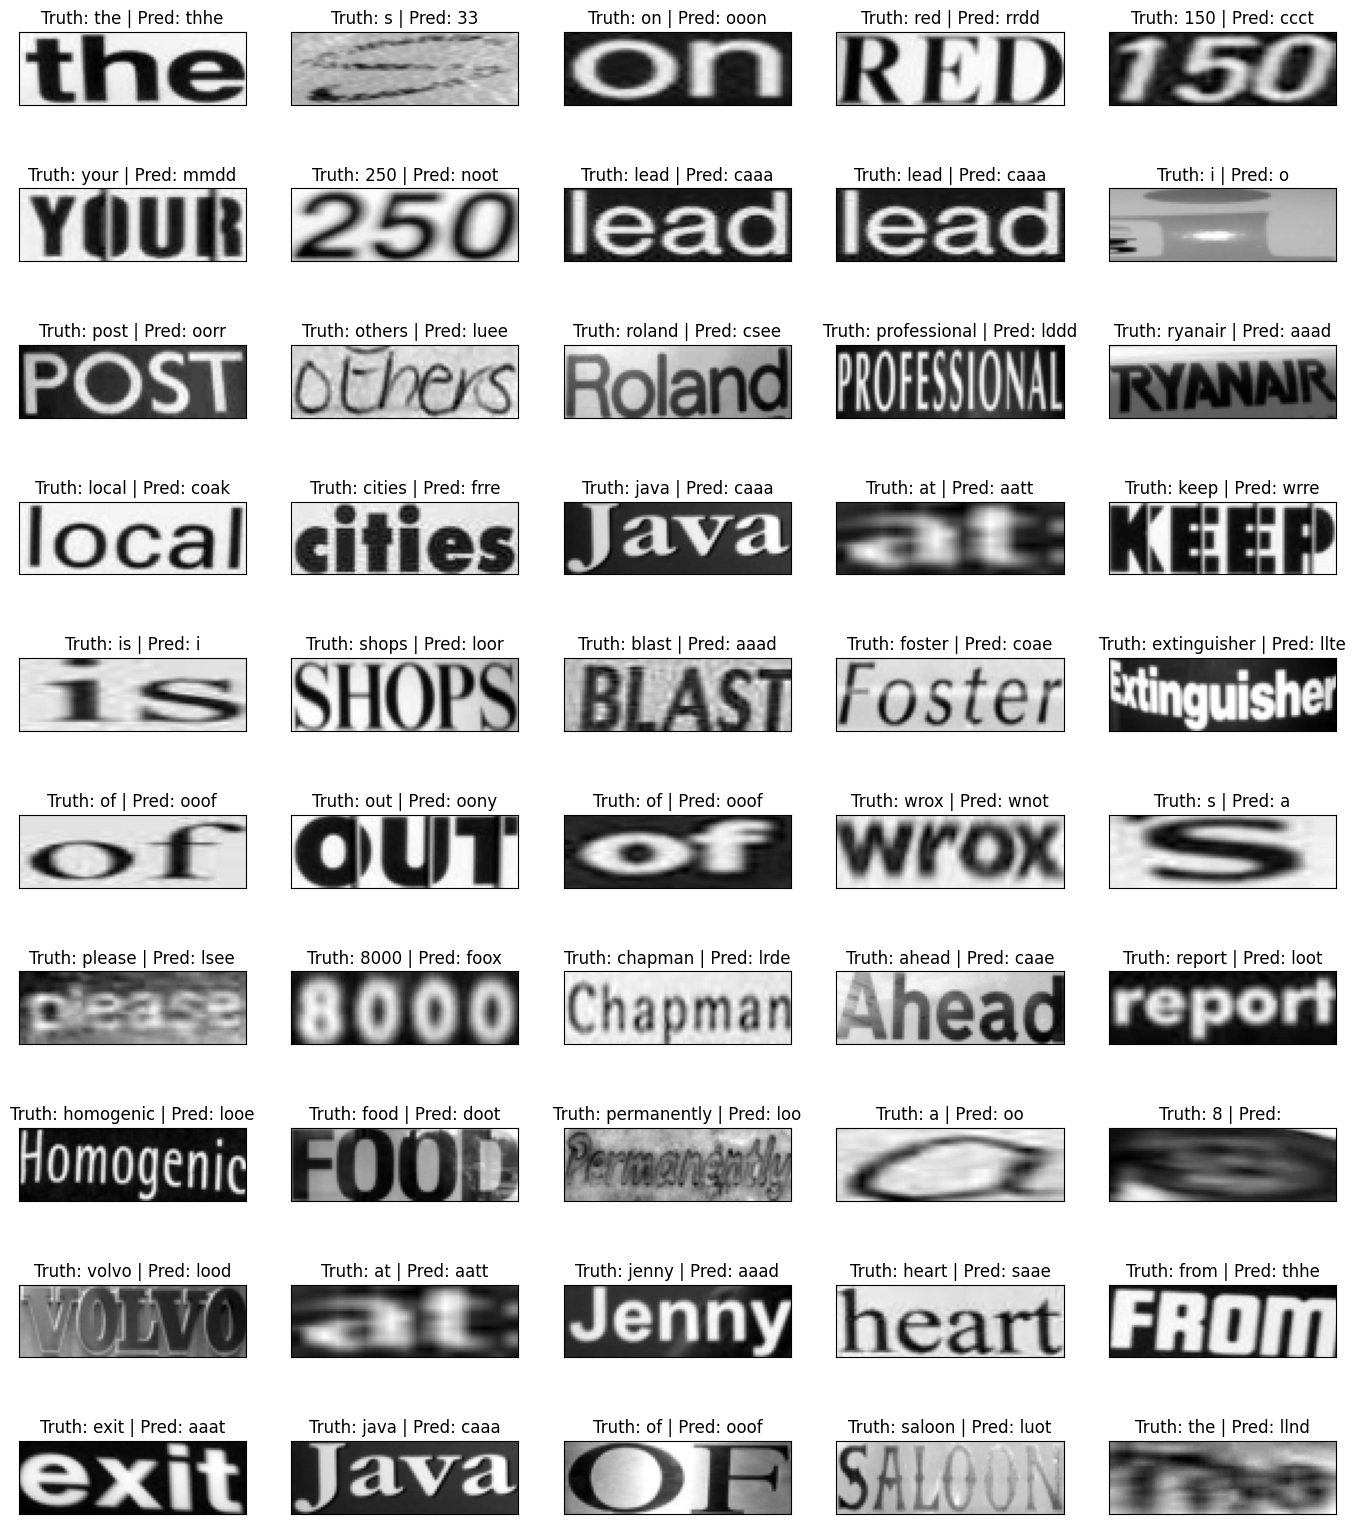

In [41]:
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = val_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

In [42]:
save_model_path = '/content/drive/MyDrive/Code/cv/OCR/model/ocr_crnn_resnet_best_1.pt'
torch.save(
    model.state_dict(),
    save_model_path
)